# Candy Data Cleaning and Transformation #


Original Column Names Preview:
['Internal ID', 'Q1: GOING OUT?', 'Q2: GENDER', 'Q3: AGE', 'Q4: COUNTRY', 'Q5: STATE, PROVINCE, COUNTY, ETC', 'Q6 | 100 Grand Bar', 'Q6 | Anonymous brown globs that come in black and orange wrappers\t(a.k.a. Mary Janes)', 'Q6 | Any full-sized candy bar', 'Q6 | Black Jacks', 'Q6 | Bonkers (the candy)', 'Q6 | Bonkers (the board game)', 'Q6 | Bottle Caps', "Q6 | Box'o'Raisins", 'Q6 | Broken glow stick', 'Q6 | Butterfinger', 'Q6 | Cadbury Creme Eggs', 'Q6 | Candy Corn', 'Q6 | Candy that is clearly just the stuff given out for free at restaurants', 'Q6 | Caramellos', 'Q6 | Cash, or other forms of legal tender', 'Q6 | Chardonnay', 'Q6 | Chick-o-Sticks (we donÕt know what that is)', 'Q6 | Chiclets', 'Q6 | Coffee Crisp', 'Q6 | Creepy Religious comics/Chick Tracts', 'Q6 | Dental paraphenalia', 'Q6 | Dots', 'Q6 | Dove Bars', 'Q6 | Fuzzy Peaches', 'Q6 | Generic Brand Acetaminophen', 'Q6 | Glow sticks', 'Q6 | Goo Goo Clusters', "Q6 | Good N' Plenty", 'Q6 | Gum from 

C:\Users\danie\AppData\Local\Temp\ipykernel_2296\2470801891.py:57: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  candy_df['timestamp'] = pd.to_datetime(candy_df['timestamp'], errors='coerce')



CANDY SURVEY ANALYSIS RESULTS

Average Ratings by Age Group:
age_group
<18      0.14
18-34    0.11
35-50    0.05
50+     -0.01
Name: rating, dtype: float64

Average Ratings by Gender:
gender
female    0.05
male      0.05
other     0.06
Name: rating, dtype: float64

Top 10 Rated Candies:
                                     avg_rating  num_ratings
candy_name                                                  
any_full_sized_candy_bar                   0.87         1027
cash_or_other_forms_of_legal_tender        0.79         1022
reese_s_peanut_butter_cups                 0.79         1021
kit_kat                                    0.77         1025
twix                                       0.75         1013
snickers                                   0.74         1014
tolberone_something_or_other               0.73         1004
lindt_truffle                              0.71          998
peanut_m_m_s                               0.66         1027
dove_bars                               

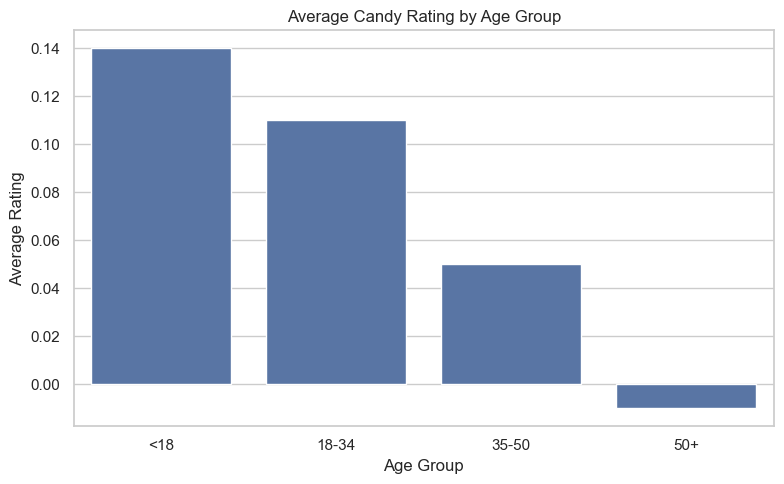

In [37]:
# Candy Data Cleaning & Transformation Analysis (Weeks 5 & 6)
# Dataset: "So Much Data, Seriously - Candy 2017"

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def main():
    # Preview Original Columns
    print("\nOriginal Column Names Preview:")
    print(pd.read_csv("candyhierarchy2017.csv", nrows=1, encoding='latin1').columns.tolist())

    # ==========================================================
    # CHAPTER 7: Data Cleaning & Transformation
    # ==========================================================
    # 7.1 Load and rename relevant columns
    candy_df = pd.read_csv("candyhierarchy2017.csv", encoding='latin1').rename(columns={
        'Q2: GENDER': 'gender',
        'Q3: AGE': 'age',
        'Q4: COUNTRY': 'country',
        'Q1: GOING OUT?': 'going_out',
        'Q5: STATE, PROVINCE, COUNTY, ETC': 'region',
        'Q11: DAY': 'timestamp'
    })

    # 7.2 Clean gender: lowercase, replace ambiguous, fill NAs
    candy_df['gender'] = (
        candy_df['gender']
        .str.lower()
        .replace({"i'd rather not say": "other"})
        .fillna('other')
    )

    # 7.3 Drop rows with missing age or country
    candy_df = candy_df.dropna(subset=['age', 'country'])

    # 7.4 Remove duplicates
    candy_df = candy_df.drop_duplicates(subset=['age', 'country', 'gender', 'timestamp'])

    # 7.5 Clean age and binning
    candy_df['age'] = pd.to_numeric(candy_df['age'], errors='coerce')
    candy_df = candy_df[candy_df['age'].between(1, 120)]
    candy_df['age_group'] = pd.cut(
        candy_df['age'],
        bins=[0, 18, 35, 50, 120],
        labels=['<18', '18-34', '35-50', '50+']
    )
    candy_df = candy_df.dropna(subset=['age_group'])

    # 7.6 Standardize country strings
    candy_df['country'] = candy_df['country'].str.upper().str.strip()

    # ==========================================================
    # CHAPTER 11: Time Series Handling
    # ==========================================================
    candy_df['timestamp'] = pd.to_datetime(candy_df['timestamp'], errors='coerce')
    print("\nValid timestamps:", candy_df['timestamp'].notna().sum())
    print("Invalid timestamps (NaT):", candy_df['timestamp'].isna().sum())
    candy_df['week'] = candy_df['timestamp'].dt.isocalendar().week

    print(f"\nTotal responses after cleaning: {len(candy_df)}")

    # ==========================================================
    # CHAPTER 8: Reshape and Merge
    # ==========================================================
    # 8.1 Identify rating columns
    rating_columns = [col for col in candy_df.columns if col.startswith('Q6 |')]

    # 8.2 Melt wide to long format
    candy_long = pd.melt(
        candy_df,
        id_vars=['age_group', 'country', 'gender', 'age'],
        value_vars=rating_columns,
        var_name='candy_name',
        value_name='rating'
    )

    # 8.3 Clean candy names
    candy_long['candy_name'] = (
        candy_long['candy_name']
        .str.replace(r'^Q6\s*\|\s*', '', regex=True)
        .str.lower()
        .str.replace(r'[^a-z0-9]+', '_', regex=True)
        .str.strip('_')
    )

    # 8.4 Merge synthetic category data
    candy_categories = pd.DataFrame({
        'candy_name': ['kit_kat', 'twix', 'snickers', 'reese_s_peanut_butter_cups'],
        'category': ['chocolate', 'chocolate', 'chocolate', 'peanut_butter']
    })
    candy_long = candy_long.merge(candy_categories, on='candy_name', how='left')

    # ==========================================================
    # CHAPTER 10: Grouping and Aggregation
    # ==========================================================
    rating_map = {'JOY': 1, 'MEH': 0, 'DESPAIR': -1}
    candy_long['rating'] = (
        candy_long['rating']
        .astype(str)
        .str.upper()
        .str.strip()
        .map(rating_map)
    )
    candy_long = candy_long.dropna(subset=['rating'])

    gender_ratings = candy_long.groupby('gender', observed=True)['rating'].mean().round(2)
    age_ratings = candy_long.groupby('age_group', observed=True)['rating'].mean().round(2)

    top_candies = (
        candy_long.groupby('candy_name')['rating']
        .agg(['mean', 'count'])
        .rename(columns={'mean': 'avg_rating', 'count': 'num_ratings'})
        .sort_values('avg_rating', ascending=False)
        .round(2)
        .head(10)
    )

    # ==========================================================
    # Final Results and Visualization
    # ==========================================================
    print("\n" + "="*50)
    print("CANDY SURVEY ANALYSIS RESULTS")
    print("="*50)

    print("\nAverage Ratings by Age Group:")
    print(age_ratings)

    print("\nAverage Ratings by Gender:")
    print(gender_ratings)

    print("\nTop 10 Rated Candies:")
    print(top_candies)

    print("\nWeekly Survey Frequencies:")
    print(candy_df['week'].value_counts().sort_index())

    print("\n" + "="*50)
    print("Analysis Complete")
    print("="*50)

    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))
    sns.barplot(x=age_ratings.index, y=age_ratings.values)
    plt.title("Average Candy Rating by Age Group")
    plt.ylabel("Average Rating")
    plt.xlabel("Age Group")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


## Chapter 11 – Date Handling
NOTE: Although we attempted to convert the timestamp column to datetime format, all values ended up as invalid (NaT). This suggests that the original date data was either missing, corrupted, or in an inconsistent format. Therefore, it was not possible to generate a time-based analysis (such as weekly frequencies).